In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy import stats
from tqdm import tqdm
import datetime
from datetime import timedelta

from scipy.integrate import trapezoid

In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

## real

In [3]:
final = pd.read_csv('./final_lung_real_202311.csv')

In [4]:
# 5년 
final.reset_index(drop = True, inplace = True)

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(final, test_size = 0.2, random_state = 42, stratify = final['DEAD'])# 0.3, 1000

In [8]:
X_train, X_test = data_train.drop(columns = ['DIFF','DEAD']), data_test.drop(columns = ['DIFF','DEAD'])

In [9]:
Y_train = []
y = np.array(data_train[['DEAD','DIFF']]).tolist()
for yy in y:
    Y_train.append(tuple(yy))

Y_train = np.array(Y_train, dtype=[('DEAD', bool), ('DIFF', int)])


Y_test = []
y = np.array(data_test[['DEAD','DIFF']]).tolist()
for yy in y:
    Y_test.append(tuple(yy))
Y_test = np.array(Y_test, dtype=[('DEAD', bool), ('DIFF', int)])

In [10]:
X_train_baseline = X_train.copy()

In [11]:
X_test_baseline, Y_test_baseline = X_test.copy(), Y_test.copy()

In [12]:
mask = (Y_test_baseline["DIFF"] < Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].max()) & (Y_test_baseline["DIFF"] > Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].min())

In [13]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=42, n_estimators=120, max_depth=8, min_samples_leaf=4, max_features=3)
rsf.fit(X_train, Y_train)

#c-index
rsf.score(X_test_baseline, Y_test_baseline)

0.7017883124428494

In [14]:
np.round(rsf.score(X_test_baseline, Y_test_baseline),4)

0.7018

## brier score

In [15]:
from sksurv.metrics import brier_score, integrated_brier_score
# mask created to enable for calculating Brier score
mask = (Y_test_baseline["DIFF"] < Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].max()) & (Y_test_baseline["DIFF"] > Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].min())
times = np.unique(np.percentile(Y_test_baseline[mask]["DIFF"], np.linspace(1, 99, 100))) #.1, 99.9, 101

survs_rsf = rsf.predict_survival_function(X_test_baseline[mask])
# survs_cph = cph.predict_survival_function(X[mask])
preds_rsf = [fn(times) for fn in survs_rsf]

brier_rsf = brier_score(Y_train, Y_test_baseline[mask], preds_rsf, times)

In [16]:
brier_real = pd.DataFrame({"time": times, "brier_score":  brier_rsf[1], "label": "RSF"})

In [17]:
np.round(brier_real['brier_score'].mean(),4)

0.0875

In [18]:
integrated_brier_score(Y_train, Y_test_baseline[mask], preds_rsf, times)

0.14541095349646865

# survival function

In [19]:
surv_funcs = rsf.predict_survival_function(X_test_baseline[mask])

lst = []
for fn in surv_funcs:
    lst.append(fn(fn.x))
    
surv_funcs_real = np.mean(lst, axis=0)

In [20]:
surv_funcs_times = []
for i, fn in enumerate(surv_funcs):
    surv_funcs_times.append(fn.x)
    if i>0:
        break
surv_funcs_times = surv_funcs_times[0]

In [21]:
surv_funcs_real = pd.DataFrame({'surv_func_real': surv_funcs_real, 'time': surv_funcs_times})

In [22]:
rsf_risk_scores = rsf.predict(X_test_baseline[mask])
rsf_auc_real, rsf_mean_auc = cumulative_dynamic_auc(Y_train, Y_test_baseline[mask], rsf_risk_scores, times)

/home/tohone06/.conda/envs/pysurv/lib/python3.9/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


## syn

In [23]:
final = pd.read_csv('./final_lung_syn_202311.csv')

In [24]:
# 5년 
final.reset_index(drop = True, inplace = True)

N = final.shape[0]

In [25]:
X_train = final.drop(columns = ['DIFF','DEAD'])

Y_train = []
y = np.array(final[['DEAD','DIFF']]).tolist()
for yy in y:
    Y_train.append(tuple(yy))

Y_train = np.array(Y_train, dtype=[('DEAD', bool), ('DIFF', int)])

In [27]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=42, n_estimators=120, max_depth=8, min_samples_leaf=4, max_features=3)
rsf.fit(X_train, Y_train)
rsf.score(X_test_baseline, Y_test_baseline)

0.6748022385650937

In [28]:
#c-index
rsf.score(X_test_baseline, Y_test_baseline)

0.6748022385650937

In [29]:
from sksurv.metrics import brier_score, integrated_brier_score
# mask created to enable for calculating Brier score
mask = (Y_test_baseline["DIFF"] < Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].max()) & (Y_test_baseline["DIFF"] > Y_test_baseline[Y_test_baseline["DEAD"]==1]["DIFF"].min())
times = np.unique(np.percentile(Y_test_baseline[mask]["DIFF"], np.linspace(1, 99, 100)))

survs_rsf = rsf.predict_survival_function(X_test_baseline[mask])
# survs_cph = cph.predict_survival_function(X[mask])
preds_rsf = [fn(times) for fn in survs_rsf]

brier_rsf = brier_score(Y_train, Y_test_baseline[mask], preds_rsf, times)

In [30]:
brier_syn = pd.DataFrame({"time": times, "brier_score":  brier_rsf[1], "label": "RSF"})

In [31]:
# Brier score
np.round(brier_syn['brier_score'].mean(),4)

0.0901

In [32]:
integrated_brier_score(Y_train, Y_test_baseline[mask], preds_rsf, times)

0.15276988258025828

In [33]:
rsf_risk_scores = rsf.predict(X_test_baseline[mask])
rsf_auc_syn, rsf_mean_auc = cumulative_dynamic_auc(Y_train, Y_test_baseline[mask], rsf_risk_scores, times)

/home/tohone06/.conda/envs/pysurv/lib/python3.9/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


# survival function

In [34]:
surv_funcs = rsf.predict_survival_function(X_test_baseline[mask])

lst = []
for fn in surv_funcs:
    lst.append(fn(fn.x))
    
surv_funcs_syn = np.mean(lst, axis=0)

In [35]:
surv_funcs_times = []
for i, fn in enumerate(surv_funcs):
    surv_funcs_times.append(fn.x)
    if i>0:
        break
surv_funcs_times = surv_funcs_times[0]

In [36]:
surv_funcs_syn = pd.DataFrame({'surv_func_syn': surv_funcs_syn, 'time': surv_funcs_times})

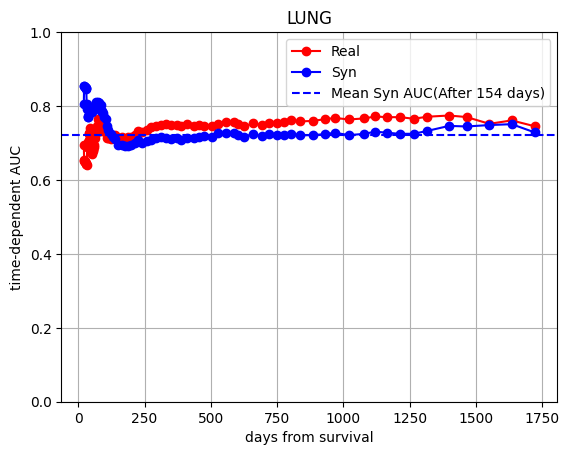

In [38]:
plt.plot(times, rsf_auc_real, marker="o", color = 'red', label = 'Real')
plt.plot(times, rsf_auc_syn, marker="o", color = 'blue', label = 'Syn')
plt.xlabel("days from survival")
plt.ylabel("time-dependent AUC")
plt.axhline(y=np.mean(rsf_auc_syn[52:]), color='blue', linestyle='--', label='Mean Syn AUC(After 154 days)')
plt.title('LUNG')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

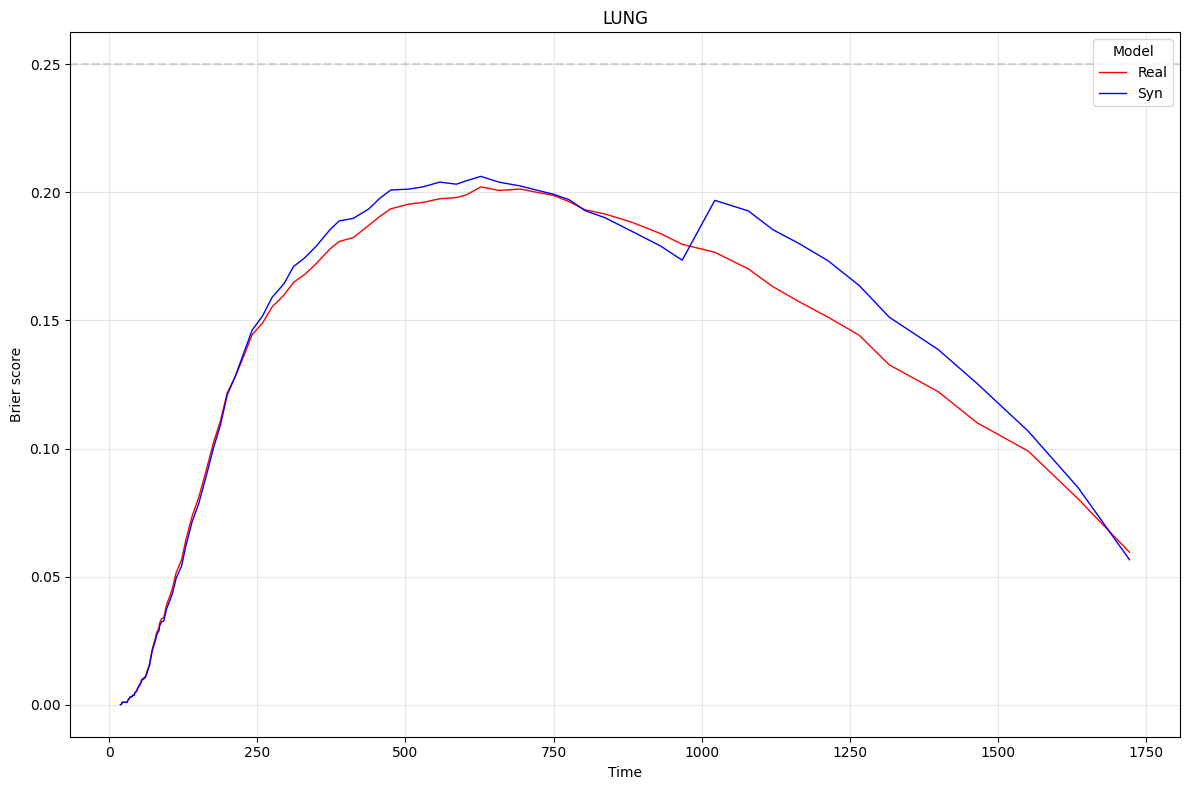

<Figure size 1000x600 with 0 Axes>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



fig, ax = plt.subplots(figsize=(12, 8))
colors = ["#4378bf", "#ae2c87"]
linetypes = [1, 5]

for label, color, linetype in zip(brier_real['label'].unique(), colors, linetypes):
    data = brier_real[brier_real['label'] == label]
    r = data['brier_score']
    ax.plot(data['time'], data['brier_score'], color='red', linestyle='-', linewidth=1, label='Real')

for label, color, linetype in zip(brier_syn['label'].unique(), colors, linetypes):
    data = brier_syn[brier_syn['label'] == label]
    s = data['brier_score']
    ax.plot(data['time'], data['brier_score'], color='blue', linestyle='-', linewidth=1, label='Syn')



rmse = round(np.sqrt(mean_squared_error(r, s)),4)

ax.axhline(y=0.25, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('Brier score')
ax.set_title('LUNG')
ax.legend(title='Model', loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.figure(figsize=(10, 6))
plt.show()